# 2.1 Expérimentation avec l’algorithme approximative Nearest Neighbors (plus proches voisins approximatifs)

### 2.1.1 Faire une synthèse de l’article avec au minimum 2 pages et un maximum de 3 pages

non fait ici

### 2.1.2 Construire un classeur binaire capable de classer les tweets en deux classes : positive et négative, selon les 4 scénarios suivants du dataset :


In [2]:
data_file_csv = "./data/source.csv"

# creation session scpark:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("AADM")
    .config("spark.driver.memory", "12g")
    .config("spark.executor.memory", "12g")
    .config("spark.sql.shuffle.partitions", "200")
    .config("spark.default.parallelism", "200")
    .config("spark.driver.extraJavaOptions", "-XX:+UseG1GC")
    .getOrCreate()
)

##### Premiere partie chargement des datas et pretraitment

1: Chargement et on nettoie

les fonctions:

In [3]:
from pyspark.sql.functions import col, regexp_replace

#On charger le CSV
def load_csv(file_path):
    df = spark.read.csv(file_path,header=False,inferSchema=True)
    return df

def nettoie_df(df,aff=False):
    # on nomme les colones
    df = df.toDF("label", "id", "date", "flag", "user", "text")

    #on allege:
    df = df.select("id","label", "text")

    #on filtre pour
    #Nettoyer les données : suppression des mots non-pertinents, articles, urls.  
    df = df.filter(col("label").isin(0, 4))
    df = df.withColumn("text", regexp_replace(col("text"), r"http\S+", ""))
    df = df.withColumn("text", regexp_replace(col("text"), r"@\w+", ""))
    df = df.withColumn("text", regexp_replace(col("text"), r"[^a-z\s]", ""))
    df = df.withColumn("text", regexp_replace(col("text"), r"\s+", " "))
    if(aff):
        df.show(5, truncate=False)
    return df

execution:

In [4]:
df = load_csv(data_file_csv)
df_propre = nettoie_df(df)

ensuite on creer une version du df avec des labels en binaire:

fonction:

In [5]:
from pyspark.sql.functions import when

def build_df_label_bin(df):
    df = df.withColumn("label_bin", when(col("label") == 4, 1).otherwise(0)) # pour passer de 0-4 a 0-1
    return df.select("id","label_bin", "text")

execution:

In [6]:
df_label_bin = build_df_label_bin(df_propre)

2) On creer les scenarios

fonctions:

In [7]:
from pyspark.sql.functions import col, concat, explode, collect_list,coalesce, array,size
from pyspark.ml.feature import Tokenizer, NGram, HashingTF

num_features = 1<<18

def make_df_Tokenizer(df_label_bin):
    tok = Tokenizer(inputCol="text", outputCol="tokens") #conversion en tokens
    df_tok = tok.transform(df_label_bin)
    return df_tok.filter(size(col("tokens")) > 0)#sinon ca crash lors des predictions

def make_df_NGram(df,ngram_n=2,outputCol="ngrams",inputCol="tokens"):
    ng = NGram(n=ngram_n, inputCol=inputCol, outputCol=outputCol)#creation des n grams
    df_ng = ng.transform(df).filter(size(col(outputCol)) > 0)
    return df_ng

def make_s1_words(df):
    df_tok = make_df_Tokenizer(df)
    tf = HashingTF(inputCol="tokens", outputCol="features", numFeatures=num_features, binary=True)
    return tf.transform(df_tok).select("id","label_bin", "features")

def make_s2_ngrams(df, ngram_n=2):
    df_tok = make_df_Tokenizer(df)
    df_ng = make_df_NGram(df_tok,ngram_n)
    tf = HashingTF(inputCol="ngrams", outputCol="features", numFeatures=num_features, binary=True)
    return tf.transform(df_ng).select("id","label_bin", "features")

def make_s3_patterns(df, ngram_n=2, topN=200000):
    df_tok = make_df_Tokenizer(df)
    df_pat0 = make_df_NGram(df_tok, ngram_n, "patterns")

    top = (df_pat0 #on creer le top
        .select(explode("patterns").alias("p"))
        .groupBy("p").count()
        .orderBy(col("count").desc())
        .limit(topN)
        .select("p")
    )

    df_pat = (df_pat0 #on filtre selon le top
        .withColumn("p", explode("patterns"))
        .join(top, on="p", how="left_semi")
        .groupBy("id", "label_bin")
        .agg(collect_list("p").alias("patterns_f"))
    )

    tf = HashingTF(inputCol="patterns_f", outputCol="features", numFeatures=num_features, binary=True)
    return tf.transform(df_pat).select("id","label_bin", "features")

def make_s4_combo(df, ngram_n=2, topN=200000):
    #on refait les 3 senarios 
    df_tok = make_df_Tokenizer(df)

    df_ng = make_df_NGram(df_tok, ngram_n, "ngrams")

    df_pat0 = make_df_NGram(df_tok, ngram_n, "patterns")

    top = (df_pat0
        .select(explode("patterns").alias("p"))
        .groupBy("p").count()
        .orderBy(col("count").desc())
        .limit(topN)
        .select("p")
    )

    df_pat = (df_pat0
        .select("id", "label_bin", "patterns")
        .withColumn("p", explode("patterns"))
        .join(top, on="p", how="left_semi")
        .groupBy("id", "label_bin")
        .agg(collect_list("p").alias("patterns_f"))
    )

    df_all = (df_ng
        .select("id", "label_bin", "tokens", "ngrams")
        .join(df_pat.select("id", "patterns_f"), on="id", how="left")
        .withColumn("patterns_f", coalesce(col("patterns_f"), array()))
    )

    df_combo = df_all.withColumn("combo", concat(col("tokens"), col("ngrams"), col("patterns_f"))).filter(size(col("combo")) > 0)

    tf = HashingTF(inputCol="combo", outputCol="features", numFeatures=num_features, binary=True)
    return tf.transform(df_combo).select("id","label_bin", "features")



3) Construction d’un classifieur binaire pour la classification des tweets

L’objectif est de construire un classifieur binaire capable de distinguer les tweets positifs et négatifs.
Dans cette section, nous définissons l’ensemble des fonctions utilitaires qui seront utilisées dans les parties 2.1.2 à 2.1.9. Ces fonctions permettront de structurer le travail, de factoriser le code et de faciliter les expérimentations ultérieures.

Nous commençons par définir une fonction permettant de séparer le jeu de données en ensembles d’entraînement et de test.

Nous ajoutons également une fonction permettant de réduire la taille du dataset,pour la futur question 2.1.7 scalabilité

In [8]:
# on split
def split_train_test(df_feat, train_ratio=0.8, cache=True):
    train_df, test_df = df_feat.randomSplit([train_ratio, 1 - train_ratio])
    if cache:
        train_df = train_df.cache()
        test_df  = test_df.cache()
        train_df.count()
        test_df.count()
    return train_df, test_df

#on limite
def limit_dataset_size(df, ratio=1.0):
    if ratio >= 1.0:
        return df
    ratio = max(0,ratio)
    return df.sample(withReplacement=False, fraction=ratio)

ensuite on creer les fonctions qui vont faire l'Entraînement (MinHashLSH):

In [9]:
from pyspark.ml.feature import MinHashLSH
import time
# pour les focntions suivantes
#  On recupere la construction dans l'exemple: LSHMinHash_datasetNetFlix.ipynb

def fit_lsh(train_df, numHashTables, measure_time=False):
    mh = MinHashLSH(
        inputCol="features",
        outputCol="hashes",
        numHashTables=numHashTables
    )
    if(measure_time):
        start = time.perf_counter()
    
    lsh_model = mh.fit(train_df)
    lsh_model.transform(train_df).count() # test pas final pour voir si ca change le temps d'execution
    
    if measure_time: #c'est dans les cas plus tard ou on voudra le temps 
        end = time.perf_counter()
        return lsh_model, float(end - start)
    return lsh_model

def train_models_for_scenario(df_feat, numHashTables_list=(128, 250), train_ratio=0.8, cache=True, measure_time=False):
    train_df, test_df = split_train_test(df_feat, train_ratio=train_ratio, cache=cache)
    models = {}
    times  = {}
    for nht in numHashTables_list:
        if measure_time:
            model, t = fit_lsh(train_df, numHashTables=int(nht), measure_time=True)
            models[int(nht)] = model
            times[int(nht)]  = t
        else:
            models[int(nht)] = fit_lsh(train_df, numHashTables=int(nht), measure_time=False)

    if measure_time:
            return models, train_df, test_df, times
    return models, train_df, test_df

Fonctions pour prédiction AkNN + vote:

In [10]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

#Prédit en batch pour tout test_df via aevc vote majoritaire.
def predict_knn(lsh_model, train_df, test_df, k, threshold=1.0):
    pairs = lsh_model.approxSimilarityJoin(
        test_df,
        train_df,
        threshold=threshold,
        distCol="JaccardDist"
    )

    neigh = pairs.select(
        F.col("datasetA.id").alias("test_id"),
        F.col("datasetA.label_bin").alias("true_label"),
        F.col("datasetB.label_bin").alias("neighbor_label"),
        F.col("JaccardDist")
    )

    w = Window.partitionBy("test_id").orderBy(F.col("JaccardDist").asc())
    topk = neigh.withColumn("rank", F.row_number().over(w)).filter(F.col("rank") <= k)

    votes = topk.groupBy("test_id").agg(
        F.first("true_label").alias("true_label"),
        F.avg("neighbor_label").alias("p_positive")
    )

    pred_df = votes.withColumn("prediction", (F.col("p_positive") >= 0.5).cast("int"))
    return pred_df


def evaluate_accuracy(pred_df):
    """
    Calcule l'accuracy de pred_df (test_id, true_label, prediction).
    """
    df_ok = pred_df.filter(F.col("true_label").isNotNull() & F.col("prediction").isNotNull())

    row = (df_ok
        .select((F.col("prediction") == F.col("true_label")).cast("int").alias("ok"))
        .agg(F.avg("ok").alias("acc"))
        .first()
    )
    acc = row["acc"]
    return float(acc) if acc is not None else 0.0

def evaluate_k_grid(lsh_model, train_df, test_df, k_list=(50, 100, 150, 200), threshold=1.0):
    """
    Évalue l'accuracy pour plusieurs valeurs de k.
    """
    results = {}
    for k in k_list:
        pred_df = predict_knn(lsh_model, train_df, test_df, k=k, threshold=threshold)
        results[k] = evaluate_accuracy(pred_df)
    return results

Ensuite pour la futur question 2.1.5 on va vouloir un tableau pour comparer a l'article donc

In [11]:
import pandas as pd

def collect_results_row(scenario_name, numHashTables, k, accuracy):
    return {"scenario": scenario_name,"numHashTables": int(numHashTables),"k": int(k),"accuracy": float(accuracy)}

def build_results_table(results_rows, as_pandas=True):
    """
    Construit le tableau de résultats.
    """
    df = pd.DataFrame(results_rows)
    if as_pandas:
        return df
    return spark.createDataFrame(df)

def format_table4_like(df_results):
    """
    Met en forme le tableau
    """
    return (df_results.pivot_table(index=["scenario", "numHashTables"],columns="k",values="accuracy").sort_index())

Fonction pour l'Histogramme pour la question 2.1.6

In [22]:
import matplotlib.pyplot as plt

def times_to_df(scenario_name, times_dict):
    return pd.DataFrame([
        {"scenario": scenario_name, "numHashTables": int(nht), "train_time_seconds": float(t)}
        for nht, t in times_dict.items()
    ])

def plot_training_histogram(df_results, group_by=("scenario","numHashTables"), value_col="train_time_seconds"):
    dfp = df_results.copy()
    dfp["group"] = dfp[list(group_by)].astype(str).agg(" | ".join, axis=1)

    agg = dfp.groupby("group")[value_col].mean()

    plt.figure()
    agg.plot(kind="bar")
    plt.xlabel("Modèle (scénario | numHashTables)")
    plt.ylabel("Temps d'entraînement (s)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

Ensuite les fonctions pour la 2.1.7, la scalabilité

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

def benchmark_scalability_vs_fraction(df_feat,scenario_name,numHashTables,F_list=(0.2, 0.4, 0.6, 0.8, 1.0),train_ratio=0.8,cache=True):
    rows = []
    for F in F_list:
        df_F = limit_dataset_size(df_feat, ratio=F)

        train_df, _ = split_train_test(df_F, train_ratio=train_ratio, cache=cache)

        _,t = fit_lsh(train_df, numHashTables=numHashTables,measure_time=True)

        rows.append({
            "scenario": scenario_name,
            "numHashTables": int(numHashTables),
            "F": float(F),
            "time_seconds": t
        })

    return pd.DataFrame(rows)

#Plot Figure 3
def plot_scalability_fraction(df_scaling, hue="scenario"):
    plt.figure()

    if hue in df_scaling.columns:
        for key, g in df_scaling.groupby(hue):
            g2 = g.groupby("F")["time_seconds"].mean().sort_index()
            plt.plot(g2.index, g2.values, marker="o", label=str(key))
        plt.legend()
    else:
        g2 = df_scaling.groupby("F")["time_seconds"].mean().sort_index()
        plt.plot(g2.index, g2.values, marker="o")

    plt.xlabel("F (fraction de la taille originale)")
    plt.ylabel("Temps d'entraînement (s)")
    plt.tight_layout()
    plt.show()

Pour la question 2.1.9, focntion simple:

In [14]:
def add_signatures(lsh_model, df_feat):
    """
    Ajoute la colonne 'hashes' (signature MinHash) au DataFrame de features.
    """
    return lsh_model.transform(df_feat)

def show_signature_examples(df_with_hashes, n=5, cols=("id", "label_bin", "hashes")):
    df_with_hashes.select(*cols).show(n, truncate=False)


### 2.1.3 Entrainer simplement chacun des 4 classeurs sans validation croisée. Le réglage des paramètres de l’algorithme approxNearestNeighbos sera uniquement sur le nombre de fonctions de hachages « numHashTables » du MinHash. Utiliser une plage de 2 valeurs maximum, par exemple {128, 250} afin de trouver la bonne longueur de la meilleure signature (réduction de dimensionnalité) 

In [20]:
NUM_HASH_LIST = (128, 250)

# quand on est en local pour pas detruire mon ordi
df_small = limit_dataset_size(df_label_bin, ratio=0.001)

#Features (les 4 scénarios)
df_s1 = make_s1_words(df_small)
df_s2 = make_s2_ngrams(df_small)
df_s3 = make_s3_patterns(df_small)
df_s4 = make_s4_combo(df_small)

#Entraînement
models_s1, train_s1, test_s1,times_s1 = train_models_for_scenario(df_s1, numHashTables_list=NUM_HASH_LIST, train_ratio=0.8, cache=True,measure_time=True)
models_s2, train_s2, test_s2,times_s2 = train_models_for_scenario(df_s2, numHashTables_list=NUM_HASH_LIST, train_ratio=0.8, cache=True,measure_time=True)
models_s3, train_s3, test_s3,times_s3 = train_models_for_scenario(df_s3, numHashTables_list=NUM_HASH_LIST, train_ratio=0.8, cache=True,measure_time=True)
models_s4, train_s4, test_s4,times_s4 = train_models_for_scenario(df_s4, numHashTables_list=NUM_HASH_LIST, train_ratio=0.8, cache=True,measure_time=True)

print("OK: modèles entraînés pour S1..S4 avec numHashTables =", NUM_HASH_LIST)

OK: modèles entraînés pour S1..S4 avec numHashTables = (128, 250)


### 2.1.4 Tester les classeurs obtenus et mesurer l’exactitude « accuracy » selon les différentes valeurs de k plus proches voisins : {50, 100, 150, 200}

In [16]:
K_LIST = (50, 100, 150, 200)

def eval_scenario(models, train_df, test_df, scenario_name):
    rows = []
    for nht, model in models.items():
        acc_by_k = evaluate_k_grid(model, train_df, test_df, k_list=K_LIST)
        for k, acc in acc_by_k.items():
            rows.append(collect_results_row(scenario_name, nht, k, acc))
    print(f"OK: {scenario_name} évalué")
    return rows

results_rows = []
results_rows += eval_scenario(models_s1, train_s1, test_s1, "S1_words")
results_rows += eval_scenario(models_s2, train_s2, test_s2, "S2_ngrams")
results_rows += eval_scenario(models_s3, train_s3, test_s3, "S3_patterns")
results_rows += eval_scenario(models_s4, train_s4, test_s4, "S4_combo")


OK: S1_words évalué
OK: S2_ngrams évalué
OK: S3_patterns évalué
OK: S4_combo évalué


### 2.1.5 Tracer le tableau des performances de classification, à l’image de la table 4 de l’article,selon les différents modèles de classeurs obtenus

In [17]:
df_results = build_results_table(results_rows)     
df_table4  = format_table4_like(df_results)
df_table4

k                               50        100       150       200
scenario    numHashTables                                        
S1_words    128            0.668539  0.676966  0.646067  0.646067
            250            0.665730  0.679775  0.654494  0.646067
S2_ngrams   128            0.604106  0.598240  0.598240  0.598240
            250            0.601173  0.598240  0.595308  0.595308
S3_patterns 128            0.664260  0.660650  0.660650  0.660650
            250            0.653430  0.653430  0.653430  0.653430
S4_combo    128            0.627219  0.615385  0.618343  0.621302
            250            0.621302  0.603550  0.615385  0.606509

### 2.1.6 Tracer le graphique (histogramme) du temps d’entrainement, à l’image de la figure 2 en mesurant le temps d’entrainement pour les différents modèles

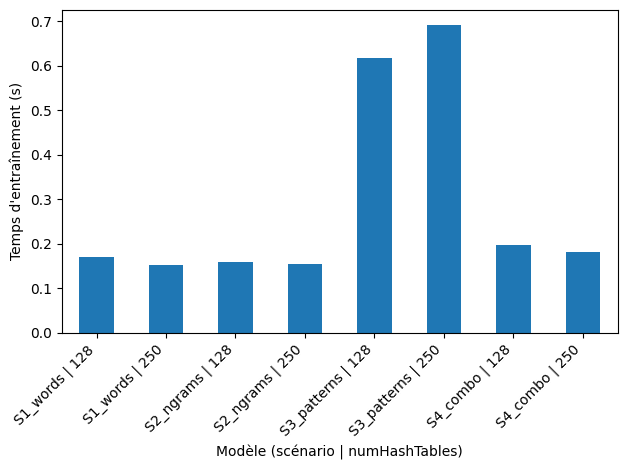

In [24]:
df_time = pd.concat([
    times_to_df("S1_words", times_s1),
    times_to_df("S2_ngrams", times_s2),
    times_to_df("S3_patterns", times_s3),
    times_to_df("S4_combo", times_s4),
], ignore_index=True)

plot_training_histogram(df_time,group_by=("scenario", "numHashTables"),value_col="train_time_seconds")


# S3 est le plus long, la raison pour la quelle s4 est pas tout aussi long c parce que le traitment a deja ete fait pour s3 donc il le refait pas

### 2.1.7 Tracer la courbe du passage à l’échelle -scalability-, à l’image de la figure 3 de l’article,pour chaque modèle entrainé

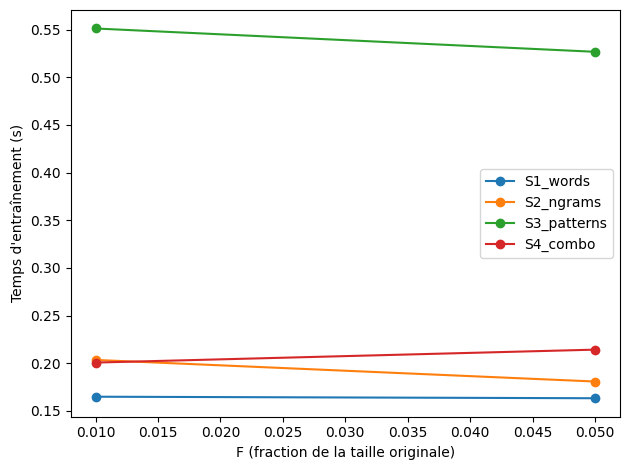

In [29]:
F_list = (0.2, 0.4, 0.6, 0.8, 1.0)
#en local:
#F_list = (0.01,0.05)

rows = []

S_all = [
            ("S1_words", df_s1),
            ("S2_ngrams", df_s2),
            ("S3_patterns", df_s3),
            ("S4_combo", df_s4),
        ]

for scenario_name, df_feat in S_all:
    for nht in NUM_HASH_LIST:
        df_tmp = benchmark_scalability_vs_fraction(
            df_feat=df_feat,
            scenario_name=scenario_name,
            numHashTables=nht,
            F_list=F_list,
            cache=True
        )
        rows.append(df_tmp)

df_scaling = pd.concat(rows, ignore_index=True)

plot_scalability_fraction(df_scaling, hue="scenario")

### 2.1.9 Afficher quelques exemples de signatures obtenues pour chaque classeur

In [33]:
N_EXAMPLES = 2
NHT = NUM_HASH_LIST[0]

S_all_model_data = [
    ("S1_words", models_s1, train_s1),
    ("S2_ngrams", models_s2, train_s2),
    ("S3_patterns", models_s3, train_s3),
    ("S4_combo", models_s4, train_s4),
]

for scenario_name, models, train_df in S_all_model_data:
    print(f"\n=== {scenario_name} | numHashTables={NHT} ===")

    lsh_model = models[NHT]

    df_with_hashes = add_signatures(lsh_model, train_df)

    show_signature_examples(
        df_with_hashes,
        n=N_EXAMPLES
    )



=== S1_words | numHashTables=128 ===
+----------+---------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------